# WeRateDogs Data Wrangling: 
# Analysis of a Twitter Archive

## Introduction

For this project, I aim to apply and refine my data wrangling skills using a real-world dataset. The process of data wrangling consists of three key stages: gathering, assessing, and cleaning. The dataset used for this project is the tweet archive of Twitter user @dog_rates, commonly known as WeRateDogs. WeRateDogs is a popular Twitter account that humorously rates people's dogs, often accompanied by amusing comments.

First, I will gather data from multiple sources and formats. Next, I will assess the data both visually and programmatically to identify data quality and tidiness issues. This includes checking for completeness, accuracy, consistency, and structure. After identifying these issues, I will clean the data using programmatic methods to ensure it is ready for analysis. Finally, I will conduct an analysis on the cleaned dataset, followed by visualizing the results to uncover any interesting insights.

The questions I aim to answer with this analysis are: What are the distributions of the different dog stages? How do these stages correlate with engagement metrics like retweet count and favorite count? Are there any trends in popularity across the dog stages over time? Additionally, I seek to explore if there are relationships between dog stages and tweet performance metrics, such as ratings, retweets, and favorites.

## Data Gathering

Before I begin data wrangling, I'm going to need to extract data from the following sources.
- Twitter archive for WeRateDogs: This contains basic tweet data for all of WeRateDog's tweets such as ID, source, dog name, rating, stage (doggo, floofer, pupper, puppo), etc.
- Tweet image prediction: This is a table of top 3 predictions of dog breeds based on the tweet images, along with the confidence of the predictions.
- Twitter API for retweet and comment counts: This obtains retweet and favorite count infomation missing from the Twitter archive.

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import requests
import json
import matplotlib.pyplot as plt
import seaborn as sb
from scipy.stats import pearsonr
%matplotlib inline

#### WeRateDogs Twitter Archive

First, I will load data from the twitter archive file into a dataframe by reading the CSV file.

In [2]:
# Read CSV file
df_twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')

df_twitter_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,NaN,NaN,NaN,NaN
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,NaN,NaN,NaN,NaN
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,NaN,NaN,NaN,NaN
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,NaN,NaN,NaN,NaN
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,NaN,NaN,NaN,NaN


#### Tweet Image Predictions

Next, I will download the tweet image predictions from the URL, then save the response as a TSV file that can be easily read.

In [3]:
# Download file using Requests library via URL provided 
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)
response

<Response [200]>

In [4]:
# Save the file
with open('image-predictions.tsv', mode = 'wb') as file:
    file.write(response.content)
    
# Read TSV file
df_image_prediction = pd.read_csv('image-predictions.tsv', sep = '\t')

df_image_prediction.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


#### Twitter API

Lastly, I will download the Twitter API data and load it into a dataframe. Specifically, I will extract the specific fields for tweet ID, retweet count, and favorite count into a list and append them to a new dataframe.

In [5]:
# Download file using Requests library via URL provided 
url = 'https://video.udacity-data.com/topher/2018/November/5be5fb7d_tweet-json/tweet-json.txt'
response = requests.get(url)

# Save the file
with open('tweet-json.txt', mode = 'wb') as file:
    file.write(response.content)

In [6]:
# Read downloaded txt file line by line into a pandas DataFrame
df_list = []
with open('tweet-json.txt', 'r') as file:
    lines = file.readlines()
    for line in lines:
        parsed_json = json.loads(line)
        df_list.append({'tweet_id': parsed_json['id'],
                        'retweet_count': parsed_json['retweet_count'],
                        'favorite_count': parsed_json['favorite_count']})
        
df_tweet_api = pd.DataFrame(df_list, columns = ['tweet_id', 'retweet_count', 'favorite_count'])

df_tweet_api.head()

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048


## Data Wrangling and Cleaning

In this section, I will familiarize myself with the data and then inspect for duplicates, nulls, or other errant data to be corrected.

### Twitter Archive

First, I will determine the shape of the WeRateDog data, as well as the data types of each column and the number duplicated and missing values.

In [7]:
df_twitter_archive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,NaN,NaN,NaN,NaN
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,NaN,NaN,NaN,NaN
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,NaN,NaN,NaN,NaN
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,NaN,NaN,NaN,NaN
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,NaN,NaN,NaN,NaN,NaN
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,NaN,NaN,NaN,NaN
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,NaN,NaN,NaN,NaN
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,NaN,NaN,NaN,NaN


In [8]:
# Reviewing the shape of the data. 
df_twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        1611 non-null   object 
 13  doggo                       97 no

In [9]:
df_twitter_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [10]:
# How many duplicates are there in the archive data frame
df_twitter_archive.duplicated().sum()

0

In [11]:
# How many duplicates are there in the Tweet ID column
df_twitter_archive.tweet_id.duplicated().sum()

0

In [12]:
df_twitter_archive.rating_denominator.value_counts()

rating_denominator
10     2333
11        3
50        3
20        2
80        2
70        1
7         1
15        1
150       1
170       1
0         1
90        1
40        1
130       1
110       1
16        1
120       1
2         1
Name: count, dtype: int64

In [13]:
df_twitter_archive.rating_numerator.value_counts()

rating_numerator
12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
2         9
1         9
75        2
15        2
420       2
0         2
80        1
144       1
17        1
26        1
20        1
121       1
143       1
44        1
60        1
45        1
50        1
99        1
204       1
1776      1
165       1
666       1
27        1
182       1
24        1
960       1
84        1
88        1
Name: count, dtype: int64

In [14]:
df_twitter_archive.doggo.value_counts()

doggo
doggo    97
Name: count, dtype: int64

In [15]:
df_twitter_archive.floofer.value_counts()

floofer
floofer    10
Name: count, dtype: int64

In [16]:
df_twitter_archive.pupper.value_counts()

pupper
pupper    257
Name: count, dtype: int64

In [17]:
df_twitter_archive.source.value_counts()

source
<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: count, dtype: int64

There are some problems with the archive data that stand out.

1) There are several columns for replies and retweets that are over 90% null entries. These can be removed to simplify the data.
2) The source column also contains useless information that is difficult to understand. This column can be changed to be easier to read.
3) The timestamp column has been incorrectly given the string data type. This will need to be converted to datetime, and the +0000 at the end should be removed.
4) The columns for doggo, floofer, pupper, and puppo are all different stages that belong to the same category and no dog is assigned more than one stage. This can be combined into one column to simplify the data.
5) There are some entries where the denominator is a number other than 10 (170, 150, 130, etc.), which is most likely a typo.
6) There are some entries where the numerator is an unusually high number (420, 1776, 666, etc.), which is most likely a typo.

### Image Prediction

In [18]:
df_image_prediction

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


In [19]:
df_image_prediction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [20]:
df_image_prediction.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [21]:
df_image_prediction.tweet_id.duplicated().sum()

0

In [22]:
df_image_prediction.jpg_url.duplicated().sum()

66

In [23]:
df_image_prediction.p1.value_counts()

p1
golden_retriever      150
Labrador_retriever    100
Pembroke               89
Chihuahua              83
pug                    57
                     ... 
pillow                  1
carousel                1
bald_eagle              1
lorikeet                1
orange                  1
Name: count, Length: 378, dtype: int64

In [24]:
df_image_prediction.p2.value_counts()

p2
Labrador_retriever    104
golden_retriever       92
Cardigan               73
Chihuahua              44
Pomeranian             42
                     ... 
medicine_chest          1
quail                   1
horse_cart              1
waffle_iron             1
bagel                   1
Name: count, Length: 405, dtype: int64

In [25]:
df_image_prediction.p3.value_counts()

p3
Labrador_retriever    79
Chihuahua             58
golden_retriever      48
Eskimo_dog            38
kelpie                35
                      ..
ox                     1
assault_rifle          1
axolotl                1
pot                    1
banana                 1
Name: count, Length: 408, dtype: int64

There are some problems with the prediction data that stand out.
1) The capitalization is inconsistent between names in the p1, p2, and p3 columns.
2) There are several duplicate values in the jpg url column.
3) There are several values in the p1, p2, and p3 columns that are not actually dog breeds and are marked as false in either the p1_dog, p2_dog, and p3_dog columns.
4) There do not need to be 3 different predictions for the dog breed, I only need the prediction with the highest confidence.
5) This entire dataset can be appended to the df_twitter_archive dataset by matching on tweet id.a typo.

### Twitter API

In [26]:
df_tweet_api

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048
...,...,...,...
2349,666049248165822465,41,111
2350,666044226329800704,147,311
2351,666033412701032449,47,128
2352,666029285002620928,48,132


In [27]:
df_tweet_api.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   tweet_id        2354 non-null   int64
 1   retweet_count   2354 non-null   int64
 2   favorite_count  2354 non-null   int64
dtypes: int64(3)
memory usage: 55.3 KB


In [28]:
df_tweet_api.duplicated().sum()

0

There are some problems with the API data that stand out.

1) This dataset can be appended to the df_twitter_archive dataset by matching on the tweet id.

In summary, both the `df_image_prediction` and `df_tweet_api` datasets can be appended to `df_twitter_archive` to create one dataset that encapsulates all the relevant data. Columns such as timestamp in `df_twitter_archive` will need to be converted to the correct datatype and format, while columns for denominator and numerator in `df_twitter_archive` need to be cleaned to remove abnormal values. Several columns in both the `df_image_prediction` and `df_tweet_api` can be deleted as they contain data that is difficult to read, contains mostly null values, or is simply irrelevant to the analysis.

## Data Cleaning

Before I begin cleaning the data, I will make copies of each dataframe for when I merge them together into one dataframe to perform my cleaning operations on.

In [29]:
# Make a copy of the tables before cleaning
df_twitter_archive_clean = df_twitter_archive.copy()
df_image_prediction_clean = df_image_prediction.copy()
df_tweet_api_clean = df_tweet_api.copy()

Now, I will combine all of the clean dataframes into a single dataframe.

In [30]:
# Append the prediction and tweet_api dataframes onto the end of the archive dataframe
df_combined = pd.concat([df_twitter_archive_clean, df_image_prediction_clean, df_tweet_api_clean], join='outer', axis=1)

#Remove all duplicate columns resulting from the merge
df_combined = df_combined.loc[:,~df_combined.columns.duplicated()]

#Confirm changes took effect
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        1611 non-null   object 
 13  doggo                       97 no

Because we only want ratings with attached pictures, I will use the `notnull` function to filter out the rows where the *jpg_url* column is null.

In [31]:
# number of null values before cleaning
df_combined.jpg_url.isnull().sum()

281

In [32]:
df_combined = (df_combined[df_combined.jpg_url.notnull()])

# number of null values after cleaning
df_combined.jpg_url.isnull().sum()

0

This will be the dataframe I perform my cleaning operations on. I'll start by changing the datatype for the timestamp column to datetime and remove the +0000 at the end of each value.

In [33]:
# Before changes to timestamp
df_combined.timestamp.head()

0    2017-08-01 16:23:56 +0000
1    2017-08-01 00:17:27 +0000
2    2017-07-31 00:18:03 +0000
3    2017-07-30 15:58:51 +0000
4    2017-07-29 16:00:24 +0000
Name: timestamp, dtype: object

In [34]:
# Remove +0000
df_combined.timestamp = df_combined.timestamp.str[:-6]

# Convert to datetime
df_combined.timestamp = pd.to_datetime(df_combined.timestamp)

#Confirm changes to timestamp
df_combined.timestamp.head()

0   2017-08-01 16:23:56
1   2017-08-01 00:17:27
2   2017-07-31 00:18:03
3   2017-07-30 15:58:51
4   2017-07-29 16:00:24
Name: timestamp, dtype: datetime64[ns]

Since I only want entries that are the original ratings of dogs, I will delete all entries that are just retweets and replies. I will do this by using `isnull()` to filter on the *retweet_status_id* and *in_reply_to_status_id* columns where the value is NaN.

In [35]:
# Remove retweets
df_combined = df_combined[df_combined.retweeted_status_id.isnull()]

# Remove replies
df_combined = df_combined[df_combined.in_reply_to_status_id.isnull()]

df_combined.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1822 entries, 0 to 2074
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   tweet_id                    1822 non-null   int64         
 1   in_reply_to_status_id       0 non-null      float64       
 2   in_reply_to_user_id         0 non-null      float64       
 3   timestamp                   1822 non-null   datetime64[ns]
 4   source                      1822 non-null   object        
 5   text                        1822 non-null   object        
 6   retweeted_status_id         0 non-null      float64       
 7   retweeted_status_user_id    0 non-null      float64       
 8   retweeted_status_timestamp  0 non-null      object        
 9   expanded_urls               1819 non-null   object        
 10  rating_numerator            1822 non-null   int64         
 11  rating_denominator          1822 non-null   int64         
 1

Since I have removed all entries for retweets and replies from the dataframe, I will drop all the 0 non-null columns related to retweets and replies.

In [36]:
df_combined = df_combined.drop(['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'],axis=1)

df_combined.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1822 entries, 0 to 2074
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            1822 non-null   int64         
 1   timestamp           1822 non-null   datetime64[ns]
 2   source              1822 non-null   object        
 3   text                1822 non-null   object        
 4   expanded_urls       1819 non-null   object        
 5   rating_numerator    1822 non-null   int64         
 6   rating_denominator  1822 non-null   int64         
 7   name                1309 non-null   object        
 8   doggo               83 non-null     object        
 9   floofer             10 non-null     object        
 10  pupper              230 non-null    object        
 11  puppo               24 non-null     object        
 12  jpg_url             1822 non-null   object        
 13  img_num             1822 non-null   float64       
 1

Next, I will change the values in the *source* column to be simpler and easier to read by replacing the urls with simple descriptive text.

In [37]:
# Before changes to source
df_combined.source.value_counts()

source
<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     1709
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          90
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       12
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: count, dtype: int64

Since there are only four unique values for *source*, I can use the `replace()` function to simplify the values to something more legible.

In [38]:
# Replace urls in source with simple text
df_combined.source = df_combined.source.replace({'<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>':'Twitter for iPhone',
                                                                     '<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>':'Vine - Make a Scene',
                                                                     '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>': 'Twitter Web Client',
                                                                     '<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>': 'TweetDeck'})

# Confirm changes to source
df_combined.source.value_counts()

source
Twitter for iPhone     1709
Vine - Make a Scene      90
Twitter Web Client       12
TweetDeck                11
Name: count, dtype: int64

Next, I will delete all entries where the dog is predicted to be something other than a dog breed. This will be done by using the `isin` function to delete rows where the values of *p1_dog*, *p2_dog*, and *p3_dog* are False.

In [39]:
df_combined['tweet_id'].isnull().sum()

0

In [40]:
# Filter posts that are not dogs and put those tweet_id into a drop_list
df_combined.query('p1_dog == False and p2_dog == False and p3_dog == False').tweet_id
drop_list = df_combined.query('p1_dog == False and p2_dog == False and p3_dog == False').tweet_id

# Drop the rows with tweet_id in the drop_list in all dataframes
df_combined = df_combined[~df_combined.tweet_id.isin(drop_list)]

#Confirm changes took effect
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1553 entries, 0 to 2073
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            1553 non-null   int64         
 1   timestamp           1553 non-null   datetime64[ns]
 2   source              1553 non-null   object        
 3   text                1553 non-null   object        
 4   expanded_urls       1550 non-null   object        
 5   rating_numerator    1553 non-null   int64         
 6   rating_denominator  1553 non-null   int64         
 7   name                1111 non-null   object        
 8   doggo               71 non-null     object        
 9   floofer             10 non-null     object        
 10  pupper              196 non-null    object        
 11  puppo               21 non-null     object        
 12  jpg_url             1553 non-null   object        
 13  img_num             1553 non-null   float64       
 1

Now, I will fix the abnormal values in the *rating_numerator* and *rating_denominator* columns.

In [41]:
df_combined.rating_denominator.value_counts()

rating_denominator
10     1539
50        3
11        2
80        2
7         1
150       1
170       1
90        1
40        1
110       1
120       1
Name: count, dtype: int64

In [42]:
df_combined.rating_numerator.value_counts()

rating_numerator
12      392
11      324
10      300
13      224
9       108
8        65
7        29
14       27
5        22
6        20
3        13
4        10
2         3
75        1
45        1
144       1
26        1
121       1
44        1
60        1
80        1
24        1
99        1
50        1
204       1
1776      1
165       1
0         1
88        1
Name: count, dtype: int64

Many of the abnormal rating values have been removed after deleting entries not related to dogs. Now, I will investigate to see what the cause of these ratings might be.

In [43]:
# Display full text
pd.set_option('display.max_colwidth', None)

# Create new temporary dataframe only for where the rating denominator is not 10.
df_abnormal_rating = df_combined[['tweet_id', 'text', 'rating_numerator', 'rating_denominator']]
df_abnormal_rating = df_abnormal_rating.query('rating_denominator != 10')
df_abnormal_rating

,tweet_id,text,rating_numerator,rating_denominator
516,810984652412424192,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,24,7
902,758467244762497024,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,165,150
1068,740373189193256964,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",9,11
1120,731156023742988288,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,204,170
1202,716439118184652801,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,50,50
1228,713900603437621249,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,99,90
1254,710658690886586372,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12,80,80
1274,709198395643068416,"From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK",45,50
1351,704054845121142784,Here is a whole flock of puppers. 60/50 I'll take the lot https://t.co/9dpcw6MdWa,60,50
1433,697463031882764288,Happy Wednesday here's a bucket of pups. 44/40 would pet all at once https://t.co/HppvrYuamZ,44,40


Most of the abnormal ratings are images with multiple dogs, and the rest give the incorrect rating by misinterpreting unrelated phrases like *24/7*, *9/11*, and *3 1/2* as ratings. Given the small number of abnormal denominators, these can be manually corrected based on the correct rating in the *text* column. 

In [44]:
# Correct ratings by reading through the text, most of the abnormal ratings are associated with multiple dogs.

# tweet_id: 810984652412424192 --- no rating
df_combined.loc[df_combined.tweet_id == 810984652412424192, 'rating_numerator'] = 10
df_combined.loc[df_combined.tweet_id == 810984652412424192, 'rating_denominator'] = 10

# tweet_id: 758467244762497024 --- Multiple dogs
df_combined.loc[df_combined.tweet_id == 758467244762497024, 'rating_numerator'] = 11
df_combined.loc[df_combined.tweet_id == 758467244762497024, 'rating_denominator'] = 10

# tweet_id: 740373189193256964 --- Replace 9/11 with 14/10
df_combined.loc[df_combined.tweet_id == 740373189193256964, 'rating_numerator'] = 14
df_combined.loc[df_combined.tweet_id == 740373189193256964, 'rating_denominator'] = 10

# tweet_id: 697463031882764288 --- Multiple dogs
df_combined.loc[df_combined.tweet_id == 697463031882764288, 'rating_numerator'] = 11
df_combined.loc[df_combined.tweet_id == 697463031882764288, 'rating_denominator'] = 10

# tweet_id: 716439118184652801 --- Replace 50/50 with 11/10
df_combined.loc[df_combined.tweet_id == 716439118184652801, 'rating_numerator'] = 11
df_combined.loc[df_combined.tweet_id == 716439118184652801, 'rating_denominator'] = 10

# tweet_id: 713900603437621249 --- Multiple dogs
df_combined.loc[df_combined.tweet_id == 713900603437621249, 'rating_numerator'] = 11
df_combined.loc[df_combined.tweet_id == 713900603437621249, 'rating_denominator'] = 10

# tweet_id: 710658690886586372 --- Multiple dogs
df_combined.loc[df_combined.tweet_id == 710658690886586372, 'rating_numerator'] = 10
df_combined.loc[df_combined.tweet_id == 710658690886586372, 'rating_denominator'] = 10

# tweet_id: 709198395643068416 --- Multiple dogs
df_combined.loc[df_combined.tweet_id == 709198395643068416, 'rating_numerator'] = 9
df_combined.loc[df_combined.tweet_id == 709198395643068416, 'rating_denominator'] = 10

# tweet_id: 704054845121142784 --- Multiple dogs
df_combined.loc[df_combined.tweet_id == 704054845121142784, 'rating_numerator'] = 12
df_combined.loc[df_combined.tweet_id == 704054845121142784, 'rating_denominator'] = 10

# tweet_id: 731156023742988288 --- Multiple dogs
df_combined.loc[df_combined.tweet_id == 731156023742988288, 'rating_numerator'] = 12
df_combined.loc[df_combined.tweet_id == 731156023742988288, 'rating_denominator'] = 10

# tweet_id: 684222868335505415 --- Multiple dogs
df_combined.loc[df_combined.tweet_id == 684222868335505415, 'rating_numerator'] = 11
df_combined.loc[df_combined.tweet_id == 684222868335505415, 'rating_denominator'] = 10

# tweet_id: 682962037429899265 --- Replace 7/11 with 10/10
df_combined.loc[df_combined.tweet_id == 682962037429899265, 'rating_numerator'] = 10
df_combined.loc[df_combined.tweet_id == 682962037429899265, 'rating_denominator'] = 10

# tweet_id: 677716515794329600 --- Multiple dogs
df_combined.loc[df_combined.tweet_id == 677716515794329600, 'rating_numerator'] = 12
df_combined.loc[df_combined.tweet_id == 677716515794329600, 'rating_denominator'] = 10

# tweet_id: 675853064436391936 --- Multiple dogs
df_combined.loc[df_combined.tweet_id == 675853064436391936, 'rating_numerator'] = 11
df_combined.loc[df_combined.tweet_id == 675853064436391936, 'rating_denominator'] = 10

# Confirm changes took effect
df_combined.rating_denominator.value_counts()

rating_denominator
10    1553
Name: count, dtype: int64

Now, I will fix the abnormal numerators using the same method.

In [45]:
df_combined.rating_numerator.value_counts()

rating_numerator
12      395
11      330
10      303
13      224
9       108
8        65
14       28
7        28
5        22
6        20
3        13
4        10
2         3
75        1
0         1
1776      1
26        1
Name: count, dtype: int64

Most of the abnormal numerators have been removed after removing the abnormal denominators, so next we will check the ratings that only have one count.

In [46]:
# Display full text
pd.set_option('display.max_colwidth', None)

# Check the rating_numerator for 75, 0, 1776, 26
df_abnormal_rating = df_combined[['tweet_id', 'text', 'rating_numerator', 'rating_denominator']]
df_abnormal_rating.query('rating_numerator == 75 or rating_numerator == 0 or rating_numerator == 1776 or rating_numerator == 26')


,tweet_id,text,rating_numerator,rating_denominator
315,835152434251116546,When you're so blinded by your systematic plagiarism that you forget what day it is. 0/10 https://t.co/YbEJPkg4Ag,0,10
695,786709082849828864,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",75,10
979,749981277374128128,This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh,1776,10
1712,680494726643068929,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,26,10


In [47]:
# Correct the ratings where the ratings where the rating does not match the text.

# tweet_id: 786709082849828864 --- Replace 75 with 9.75
df_combined.loc[df_combined.tweet_id == 786709082849828864, 'rating_numerator'] = 9.75

# tweet_id: 749981277374128128 --- Replace 1776 with 10
df_combined.loc[df_combined.tweet_id == 749981277374128128, 'rating_numerator'] = 10

# tweet_id: 680494726643068929 --- Replace 26 with 11.26
df_combined.loc[df_combined.tweet_id == 680494726643068929, 'rating_numerator'] = 11.26

C:\Users\pccra\AppData\Local\Temp\ipykernel_9668\1038267020.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9.75' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_combined.loc[df_combined.tweet_id == 786709082849828864, 'rating_numerator'] = 9.75


I will now check some of the other low count numerators to make sure that there are no differences between the assigned rating and the ratings in the text.

In [48]:
# Display full text
pd.set_option('display.max_colwidth', None)

# Check the rating_numerator for 1, 2, 3, 4
df_abnormal_rating = df_combined[['tweet_id', 'text', 'rating_numerator', 'rating_denominator']]
df_abnormal_rating.query('rating_numerator == 1 or rating_numerator == 2 or rating_numerator == 3 or rating_numerator == 4')

,tweet_id,text,rating_numerator,rating_denominator
765,777885040357281792,This is Wesley. He's clearly trespassing. Seems rather h*ckin violent too. Weaponized forehead. 3/10 wouldn't let in https://t.co/pL7wbMRW7M,3.0,10
883,760252756032651264,This is Fido. He can tell the weather. Not good at fetch tho. Never comes when called. 4/10 would probably still pet https://t.co/4gOv2Q3iKP,4.0,10
912,757596066325864448,Here's another picture without a dog in it. Idk why you guys keep sending these. 4/10 just because that's a neat rug https://t.co/mOmnL19Wsl,4.0,10
1004,747816857231626240,Viewer discretion is advised. This is a terrible attack in progress. Not even in water (tragic af). 4/10 bad sherk https://t.co/L3U0j14N5R,4.0,10
1189,718246886998687744,This is Alexanderson. He's got a weird ass birth mark. Dreadful at fetch. Won't eat kibble. 3/10 wtf @Target https://t.co/FmxOpf2Sgl,3.0,10
1219,714631576617938945,This is Benedict. He's a feisty pup. Needs a brushing. Portable af. Looks very angry actually. 4/10 might not pet https://t.co/3oeFfHjv0Z,4.0,10
1249,711306686208872448,What hooligan sent in pictures w/out a dog in them? Churlish af. 3/10 just bc that's a neat fluffy bean bag chair https://t.co/wcwoGOkZvz,3.0,10
1303,707420581654872064,This is Keurig. He's a rare dog. Laughs like an idiot tho. Head is basically a weapon. Poorly maintained goatee 4/10 https://t.co/xOrUyj7K30,4.0,10
1314,706901761596989440,This is Elliot. He's blocking the roadway. Downright rude as hell. Doesn't care that you're already late. 3/10 https://t.co/FMUxir5pYu,3.0,10
1406,699088579889332224,This is Charl. He's a bully. Chucks that dumbbell around like its nothing. Sharp neck. Exceptionally unfluffy. 3/10 https://t.co/VfLoDZecJ7,3.0,10


I cannot see any other issues with the numerator, so I will say that this issue has been resolved.

Next, since we only need the most confident prediction for dog breed, I will determine between columns p1, p2, and p3 which has the most confident predictions and add them to new columns for breed and confidence. Then, I will drop all other remaining prediction columns.

In [49]:
# Create a breed column and a confident_level column
breed = []
confident_level = []

# Create a function to find the most confident prediction that is a dog breed
# p1 is the most confident prediction, followed by p2 and p3
def image_pred(df_combined):
    if df_combined.p1_dog == True:
        breed.append(df_combined.p1)
        confident_level.append(df_combined.p1_conf)
    elif df_combined.p2_dog == True:
        breed.append(df_combined.p2)
        confident_level.append(df_combined.p2_conf)
    elif df_combined.p3_dog == True:
        breed.append(df_combined.p3)
        confident_level.append(df_combined.p3_conf)
    else:
        breed.append('Unknown_breed')
        confident_level.append(0)
        
# Apply the function by column        
df_combined.apply(image_pred, axis=1)

# Add the breed and confident_level column to image_prediction_clean 
df_combined['breed'] = breed
df_combined['confidence'] = confident_level

# Drop columns no longer needed
df_combined = df_combined.drop(['img_num',
                                'p1','p1_conf','p1_dog',
                                'p2','p2_conf','p2_dog',
                                'p3','p3_conf','p3_dog'],axis=1)

# Confirm changes took effect
df_combined.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,jpg_url,retweet_count,favorite_count,breed,confidence
0,892420643555336193,2017-08-01 16:23:56,Twitter for iPhone,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13.0,10,Phineas,NaN,NaN,NaN,NaN,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,8853.0,39467.0,Welsh_springer_spaniel,0.465074
1,892177421306343426,2017-08-01 00:17:27,Twitter for iPhone,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13.0,10,Tilly,NaN,NaN,NaN,NaN,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,6514.0,33819.0,redbone,0.506826
2,891815181378084864,2017-07-31 00:18:03,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12.0,10,Archie,NaN,NaN,NaN,NaN,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,4328.0,25461.0,German_shepherd,0.596461
3,891689557279858688,2017-07-30 15:58:51,Twitter for iPhone,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13.0,10,Darla,NaN,NaN,NaN,NaN,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,8964.0,42908.0,Rhodesian_ridgeback,0.408143
4,891327558926688256,2017-07-29 16:00:24,Twitter for iPhone,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f","https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12.0,10,Franklin,NaN,NaN,NaN,NaN,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,9774.0,41048.0,miniature_pinscher,0.560311


Now, I will fix the inconsistent capitalization in the dog breed names.

In [50]:
# Capitalize all breed names
df_combined.breed = df_combined.breed.str.capitalize()

# Confirm capitalization was successful
df_combined.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,jpg_url,retweet_count,favorite_count,breed,confidence
0,892420643555336193,2017-08-01 16:23:56,Twitter for iPhone,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13.0,10,Phineas,NaN,NaN,NaN,NaN,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,8853.0,39467.0,Welsh_springer_spaniel,0.465074
1,892177421306343426,2017-08-01 00:17:27,Twitter for iPhone,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13.0,10,Tilly,NaN,NaN,NaN,NaN,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,6514.0,33819.0,Redbone,0.506826
2,891815181378084864,2017-07-31 00:18:03,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12.0,10,Archie,NaN,NaN,NaN,NaN,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,4328.0,25461.0,German_shepherd,0.596461
3,891689557279858688,2017-07-30 15:58:51,Twitter for iPhone,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13.0,10,Darla,NaN,NaN,NaN,NaN,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,8964.0,42908.0,Rhodesian_ridgeback,0.408143
4,891327558926688256,2017-07-29 16:00:24,Twitter for iPhone,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f","https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12.0,10,Franklin,NaN,NaN,NaN,NaN,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,9774.0,41048.0,Miniature_pinscher,0.560311


Next, because the *doggo*, *floofer*, *pupper*, and *puppo* columns are all describing the same characteristic and do not have overlapping values, I will combine the column values into one single column named *dog_stage*, and the old column names will be compiled into another column called *old* to be deleted.

In [51]:
# Melt the doggo, floofer, pupper and puppo columns to type and dogs_stage column
df_combined = pd.melt(df_combined, 
                            id_vars = ['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls', 'rating_numerator', 'rating_denominator', 'name', 'jpg_url', 'breed', 'confidence', 'retweet_count', 'favorite_count'],
                            value_vars = ['doggo', 'floofer', 'pupper', 'puppo'], 
                            var_name = 'old', 
                            value_name = 'dog_stage')

# Replace null values in dog_stage with "None"
df_combined['dog_stage'].fillna('None', inplace=True)

# Drop the old column
df_combined.drop('old', axis=1, inplace=True)

# Sort the dataframe by dog_stage and drop duplicates resulting from the melt
df_combined = df_combined.sort_values('dog_stage').drop_duplicates(subset='tweet_id', keep='last')

# Ensure there are values in dog_stage before counting
if not df_combined.empty:
    dog_stage_counts = df_combined.dog_stage.value_counts()
    print(dog_stage_counts)
else:
    print("No data available to count.")


dog_stage
None       1264
pupper      196
doggo        62
puppo        21
floofer      10
Name: count, dtype: int64


C:\Users\pccra\AppData\Local\Temp\ipykernel_9668\3248001697.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_combined['dog_stage'].fillna('None', inplace=True)


In [52]:
df_combined.dog_stage.value_counts()

dog_stage
None       1264
pupper      196
doggo        62
puppo        21
floofer      10
Name: count, dtype: int64

I will now look at the cleaned `df_combined` dataframe.

In [53]:
df_combined.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,jpg_url,breed,confidence,retweet_count,favorite_count,dog_stage
1499,672222792075620352,2015-12-03 01:16:17,Twitter for iPhone,This is Cal. He's a Swedish Geriatric Cheddar. Upset because the pope is laughing at his eyebrows. 9/10 https://t.co/EW4MsOrF5O,https://twitter.com/dog_rates/status/672222792075620352/photo/1,9.0,10,Cal,https://pbs.twimg.com/ext_tw_video_thumb/879415784908390401/pu/img/cX7XI1TnUsseGET5.jpg,English_springer,0.383404,408.0,1074.0,None
1498,672231046314901505,2015-12-03 01:49:05,Twitter for iPhone,Exotic underwater dog here. Very shy. Wont return tennis balls I toss him. Never been petted. 5/10 I bet he's soft https://t.co/WH7Nzc5IBA,https://twitter.com/dog_rates/status/672231046314901505/photo/1,5.0,10,NaN,https://pbs.twimg.com/media/DDQsQGFV0AAw6u9.jpg,Labrador_retriever,0.033496,1270.0,2414.0,None
1497,672245253877968896,2015-12-03 02:45:32,Twitter for iPhone,Meet Snickers. He's adorable. Also comes in t-shirt mode. 12/10 I would aggressively caress Snickers https://t.co/aCRKDaFmVr,https://twitter.com/dog_rates/status/672245253877968896/photo/1,12.0,10,Snickers,https://pbs.twimg.com/media/DDLdUrqXYAMOVzY.jpg,Vizsla,0.960513,1089.0,1956.0,None
1496,672248013293752320,2015-12-03 02:56:30,Twitter for iPhone,10/10 for dog. 7/10 for cat. 12/10 for human. Much skill. Would pet all https://t.co/uhx5gfpx5k,https://twitter.com/dog_rates/status/672248013293752320/photo/1,10.0,10,NaN,https://pbs.twimg.com/media/DDIKMXzW0AEibje.jpg,Italian_greyhound,0.734684,347.0,953.0,None
1494,672256522047614977,2015-12-03 03:30:19,Twitter for iPhone,Mighty rare dogs here. Long smooth necks. Great knees. Travel in squads. 1 out of every 14 is massive. 8/10 for all https://t.co/PoMKKnKpRd,https://twitter.com/dog_rates/status/672256522047614977/photo/1,8.0,10,NaN,https://pbs.twimg.com/media/DC98vABUIAA97pz.jpg,French_bulldog,0.839097,656.0,1833.0,None


In [54]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1553 entries, 1499 to 5365
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            1553 non-null   int64         
 1   timestamp           1553 non-null   datetime64[ns]
 2   source              1553 non-null   object        
 3   text                1553 non-null   object        
 4   expanded_urls       1550 non-null   object        
 5   rating_numerator    1553 non-null   float64       
 6   rating_denominator  1553 non-null   int64         
 7   name                1111 non-null   object        
 8   jpg_url             1553 non-null   object        
 9   breed               1553 non-null   object        
 10  confidence          1553 non-null   float64       
 11  retweet_count       1553 non-null   float64       
 12  favorite_count      1553 non-null   float64       
 13  dog_stage           1553 non-null   object        

Now that the dataframe looks fully cleaned, I will save the cleaned dataframe in a CSV file and move onto the data visualization section.

In [55]:
# Store the clean dataframe in a CSV file named twitter_archive_master.csv
df_combined.to_csv('twitter_archive_master.csv')

# load data to a dataframe for data visualization
df = pd.read_csv('twitter_archive_master.csv')

## Data Visualization

First, I want to see the most popular dog breeds based on the following:
1) Original tweet count
2) Total retweet count
3) Total favorite count

In [56]:
df.breed.value_counts()

breed
Golden_retriever           158
Labrador_retriever         101
Chihuahua                   85
Pembroke                    80
Pug                         62
                          ... 
Japanese_spaniel             1
Bouvier_des_flandres         1
Black-and-tan_coonhound      1
Silky_terrier                1
Scotch_terrier               1
Name: count, Length: 112, dtype: int64

First, I will create a bar chart that shows the top 10 most popular dog breeds based on original tweets only.

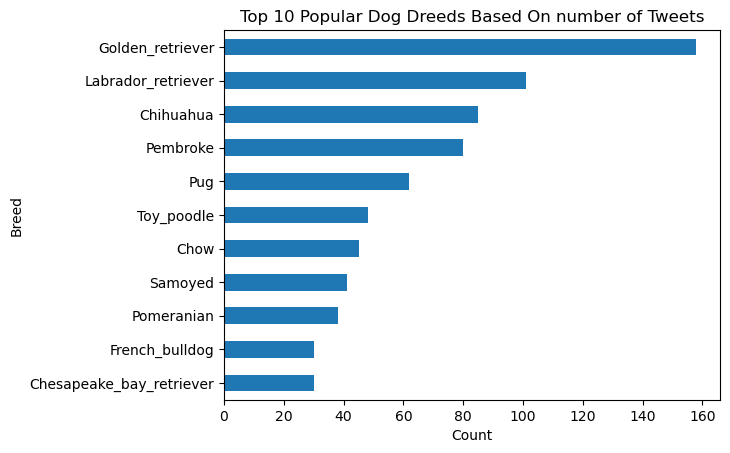

In [57]:
# Plot bar chart for top 10 popular breeds based on number of original tweets
df.breed.value_counts()[10::-1].plot(kind = 'barh', title = 'Top 10 Popular Dog Dreeds Based On number of Tweets')
plt.xlabel('Count')
plt.ylabel('Breed');

The bar chart shows that Golder retriever is the most common dog breed at 158 tweets, with Labrador retriver being the 2nd most common breed at 101 tweets and Chihuahua the 3rd most common breed at 85 tweets. Next, I'll plot the most popular dog breeds for both retweets and favorites.

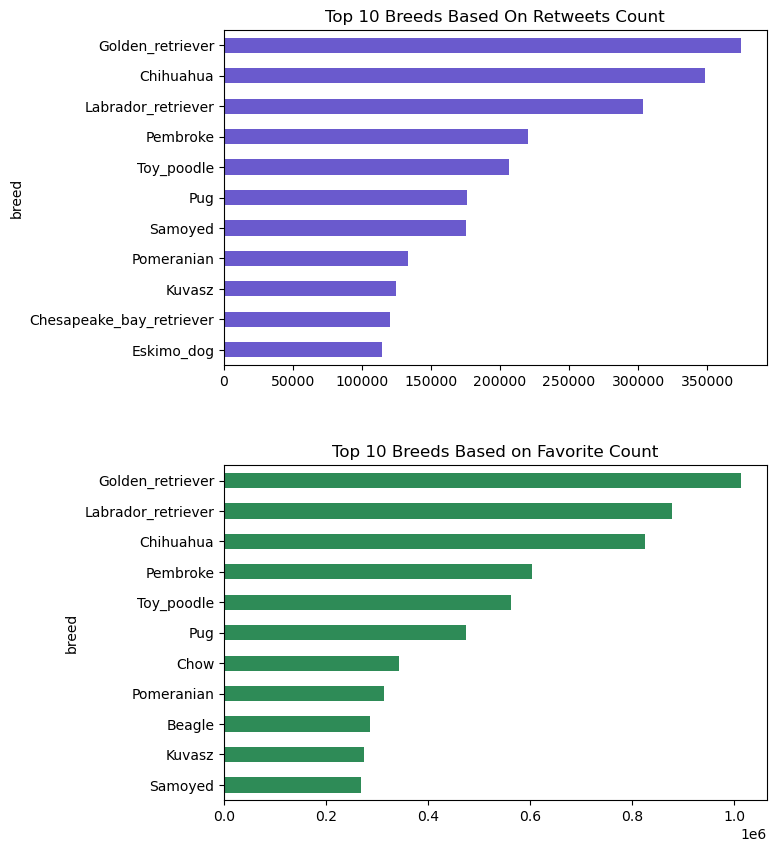

In [58]:
# Data to plot
columns = ['breed', 'retweet_count', 'favorite_count']
df_breed = df[columns]

breed_retweet = df_breed.groupby('breed')['retweet_count'].agg('sum').sort_values(ascending=False)[10::-1]
breed_favorite = df_breed.groupby('breed')['favorite_count'].agg('sum').sort_values(ascending=False)[10::-1]

# Plot horizontal bar chart
fig, (ax1, ax2) = plt.subplots(2, 1)

# Top 10 breeds based on number of retweets
breed_retweet.plot.barh(ax=ax1, figsize=(7,10), color='#6A5ACD')
ax1.set_title("Top 10 Breeds Based On Retweets Count")

# Top 10 breeds based on number of favorite
breed_favorite.plot.barh(ax=ax2, color='#2E8B57')
ax2.set_title("Top 10 Breeds Based on Favorite Count")

fig.subplots_adjust(hspace=0.3)

The bar charts show that the Golden retriever, Labrador retriever, and Chihuahua are all in the Top 3 for both retweets and favorites, with Golden retreiver being the top pick for both. Pembroke, Toy poodle, Pug, Samoyed, Pomeranian, Kuvasz are all in the Top 10 for both retweets and favorites.

Next, I will see what the most common dog stage among all tweet that had a stage.

In [59]:
# Replace null values in dog_stage with "None"
df['dog_stage'].fillna('None', inplace=True)

# Dog stage and count
df.dog_stage.value_counts(normalize=True)

C:\Users\pccra\AppData\Local\Temp\ipykernel_9668\1508910793.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['dog_stage'].fillna('None', inplace=True)


dog_stage
None       0.813909
pupper     0.126207
doggo      0.039923
puppo      0.013522
floofer    0.006439
Name: proportion, dtype: float64

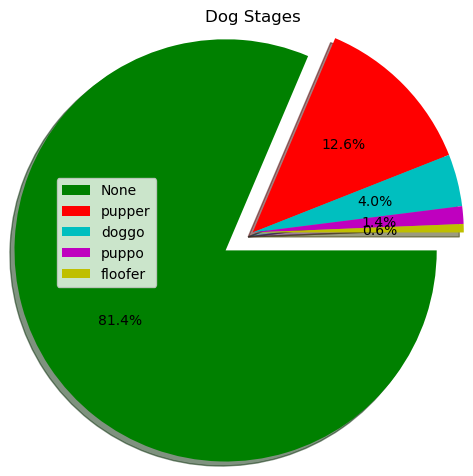

In [60]:
# Plot pie chart
labels = ['None', 'pupper', 'doggo', 'puppo', 'floofer']
values = df.dog_stage.value_counts(normalize=True)
colors = ['g', 'r', 'c' ,'m', 'y']
explode = (0.2, 0, 0, 0, 0)

plt.pie(values, colors=colors, explode=explode, autopct='%1.1f%%', radius = 1.3, shadow=True, counterclock=False)
plt.legend(labels, loc=0)
plt.title('Dog Stages')
plt.tight_layout()

The pie chart shows that more than 80% of tweets gave no information for dog stage. However, out of the tweets that did have stage information, pupper was the most common.

Now, I will look to see the distribution of the rating numerators for all tweets. Since the rating denominator has been standarized to 10, I only need to focus on the numerator.

In [61]:
df.rating_numerator.value_counts()

rating_numerator
12.00    395
11.00    330
10.00    304
13.00    224
9.00     108
8.00      65
7.00      28
14.00     28
5.00      22
6.00      20
3.00      13
4.00      10
2.00       3
11.26      1
9.75       1
0.00       1
Name: count, dtype: int64

In [62]:
df.rating_numerator.describe()

count    1553.000000
mean       10.777856
std         2.001126
min         0.000000
25%        10.000000
50%        11.000000
75%        12.000000
max        14.000000
Name: rating_numerator, dtype: float64

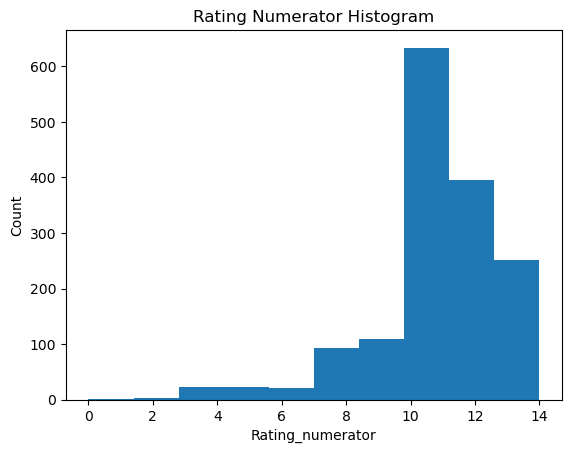

In [63]:
plt.hist(df.rating_numerator)
plt.title('Rating Numerator Histogram')
plt.xlabel('Rating_numerator')
plt.ylabel('Count');

The histogram shows that the most common ratings are an 12/10 at 395 tweets, 11/10 at 330 tweets, 10/10 at 304 tweets, and 13/10 at 224 tweets, with an average rating of 10.78/10.

Next, I will determine the average ratings for popular dog breeds based on tweet count.

In [64]:
# Make a list of top popular dog breeds based on number of tweets
top_tweet_count = df.breed.value_counts().sort_values(ascending=False).nlargest(10).rename_axis('dog_breed').reset_index(name='tweet_counts')
breed_list = top_tweet_count.dog_breed.tolist()

# Average rating for top breeds based on number of tweets
avg_rating = df.groupby('breed').rating_numerator.mean().sort_values(ascending=False).rename_axis('breed').reset_index(name='avg_rating')
breed_avg_rating = avg_rating[avg_rating['breed'].isin(breed_list)]

breed_avg_rating

,breed,avg_rating
23,Pomeranian,11.526316
34,Chihuahua,11.235294
37,Toy_poodle,11.187500
44,Pug,11.048387
45,Samoyed,11.024390
59,Labrador_retriever,10.779703
70,Chow,10.555556
77,Golden_retriever,10.500000
78,Pembroke,10.450000
95,French_bulldog,9.933333


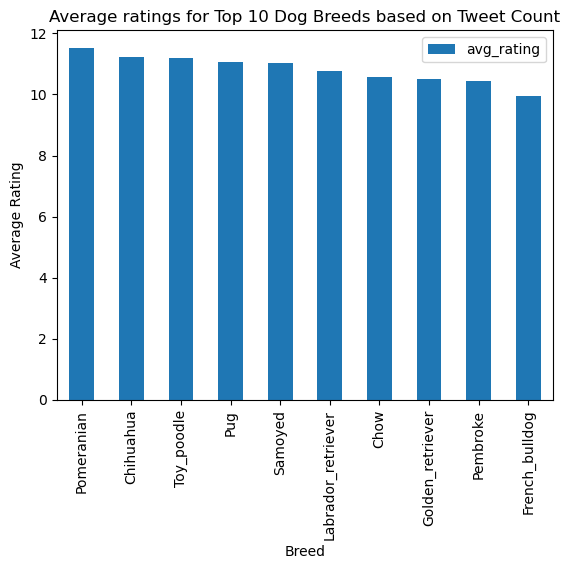

In [65]:
# Plot chart
breed_avg_rating.plot(kind='bar', x='breed', y='avg_rating')  
plt.title('Average ratings for Top 10 Dog Breeds based on Tweet Count')
plt.ylabel("Average Rating")
plt.xlabel("Breed");

The histogram shows that average ratings for the top 10 dog breeds are very similar to each other, between 12/10 and 10/10.

Finally, I will determine the most common source of tweets.

In [66]:
df.source.value_counts()

source
Twitter for iPhone     1458
Vine - Make a Scene      78
Twitter Web Client        9
TweetDeck                 8
Name: count, dtype: int64

In [67]:
df.source.value_counts(normalize=True)

source
Twitter for iPhone     0.938828
Vine - Make a Scene    0.050225
Twitter Web Client     0.005795
TweetDeck              0.005151
Name: proportion, dtype: float64

The iPhone is the most common source of tweets for WeRateDogs.